In [779]:
import numpy as np
import pandas as pd

In [780]:
#if you are using google colab you have to update the fbprophet
#!pip uninstall -y prophet fbprophet pystan cmdstanpy
#!pip install prophet cmdstanpy --quiet

##Data Processing

Dataset- https://archive.ics.uci.edu/ml/datasets/air+quality



The doc of the data set mentioned there are **two unnamed col** at the end so we will remote it.

Also, there are corrupted data rows. the doc said **rows after 1957 are corrupted** so we will only take [0, 9357]

In [781]:
#loading data
air_quality_data = pd.read_csv('/content/AirQualityUCI.csv', sep=';', decimal=',')

#remove unnamed col
air_quality_data = air_quality_data.iloc[:, :-2]

#remove corrupted data
air_quality_data = air_quality_data.head(9357)

In [782]:
#check the head, shape, and tail to make sure the corrupted data are removed.
air_quality_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [783]:
air_quality_data.shape

(9357, 15)

In [784]:
air_quality_data.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,04/04/2005,14.00.00,2.2,1071.0,-200.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


In [785]:
#get the info about the imported data
air_quality_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [786]:
#check missing data
air_quality_data.isnull().sum()

,0
Date,0
Time,0
CO(GT),0
PT08.S1(CO),0
NMHC(GT),0
C6H6(GT),0
PT08.S2(NMHC),0
NOx(GT),0
PT08.S3(NOx),0
NO2(GT),0


In most case you can check with null function.

Since doc stated missing values are tag as -200, we have to use different approach

In [787]:
#counting total times of -200 appearance
air_quality_data.isin([-200]).sum()

,0
Date,0
Time,0
CO(GT),1683
PT08.S1(CO),366
NMHC(GT),8443
C6H6(GT),366
PT08.S2(NMHC),366
NOx(GT),1639
PT08.S3(NOx),366
NO2(GT),1642


#Handling the missing values

-convert all the -200 into the NaN

-replace Nan with the mean value of the coresponding column

In [788]:
#replace -200 with Nan
air_quality_data = air_quality_data.replace(to_replace=-200, value = np.nan)

In [789]:
#replace NaN with mean
air_quality_data = air_quality_data.fillna(air_quality_data.mean(numeric_only=True))

In [790]:
air_quality_data.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,04/04/2005,10.00.00,3.1,1314.0,218.811816,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,218.811816,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,218.811816,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,218.811816,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,04/04/2005,14.00.00,2.2,1071.0,218.811816,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


In [791]:
air_quality_data.mean(numeric_only=True)

,0
CO(GT),2.152750
PT08.S1(CO),1099.833166
NMHC(GT),218.811816
C6H6(GT),10.083105
PT08.S2(NMHC),939.153376
NOx(GT),246.896735
PT08.S3(NOx),835.493605
NO2(GT),113.091251
PT08.S4(NO2),1456.264598
PT08.S5(O3),1022.906128


# Forecasting with FB Prophet Algorithm

doc: https://facebook.github.io/prophet/docs/quick_start.html

In [792]:
#convert the date form DD/MM/YYYY to YYYY-MM-DD
#air_quality_data['Date'] = pd.to_datetime(air_quality_data['Date'], format='%d/%m/%Y')
#air_quality_data['Date'] = air_quality_data['Date'].dt.strftime('%Y-%m-%d')

In [793]:
air_quality_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [794]:
date_info = pd.to_datetime(air_quality_data['Date'], dayfirst=True)

In [795]:
time_info = air_quality_data['Time']
time_info = time_info.apply(lambda x:x.replace('.', ':'))

In [796]:
date_info

,Date
0,2004-03-10
1,2004-03-10
2,2004-03-10
3,2004-03-10
4,2004-03-10
...,...
9352,2005-04-04
9353,2005-04-04
9354,2005-04-04
9355,2005-04-04


In [797]:
air_quality_data.isnull().sum()
#checking any Null value remain in the dataset

,0
Date,0
Time,0
CO(GT),0
PT08.S1(CO),0
NMHC(GT),0
C6H6(GT),0
PT08.S2(NMHC),0
NOx(GT),0
PT08.S3(NOx),0
NO2(GT),0


In [798]:
#conbine two series to a pandas dataframe
date_time = pd.concat([date_info, time_info], axis=1)

In [799]:
date_time.shape

(9357, 2)

In [800]:
#combining data and time
date_time['ds'] = date_time['Date'].astype(str) + ' ' + date_time['Time'].astype(str)
#the output will be object (string) so we have to change it into datetime datatype

In [801]:
date_time

,Date,Time,ds
0,2004-03-10,18:00:00,2004-03-10 18:00:00
1,2004-03-10,19:00:00,2004-03-10 19:00:00
2,2004-03-10,20:00:00,2004-03-10 20:00:00
3,2004-03-10,21:00:00,2004-03-10 21:00:00
4,2004-03-10,22:00:00,2004-03-10 22:00:00
...,...,...,...
9352,2005-04-04,10:00:00,2005-04-04 10:00:00
9353,2005-04-04,11:00:00,2005-04-04 11:00:00
9354,2005-04-04,12:00:00,2005-04-04 12:00:00
9355,2005-04-04,13:00:00,2005-04-04 13:00:00


In [802]:
data = pd.DataFrame()
# Parse the combined date and time string using the standard 'YYYY-MM-DD HH:MM:SS' format
data['ds'] = pd.to_datetime(date_time['ds'], format='%Y-%m-%d %H:%M:%S')
data['y'] = air_quality_data['RH']
#replace 'RH' with any col you want to predict.

In [803]:
data.head()

,ds,y
0,2004-03-10 18:00:00,48.9
1,2004-03-10 19:00:00,47.7
2,2004-03-10 20:00:00,54.0
3,2004-03-10 21:00:00,60.0
4,2004-03-10 22:00:00,59.6


In [804]:
data.tail()

,ds,y
9352,2005-04-04 10:00:00,29.3
9353,2005-04-04 11:00:00,23.7
9354,2005-04-04 12:00:00,18.3
9355,2005-04-04 13:00:00,13.5
9356,2005-04-04 14:00:00,13.1


#Setting up Prophet model

In [805]:
from prophet import Prophet

loading data to predict Relative Humidity

In [806]:
model = Prophet(yearly_seasonality=False)
model.fit(data)

In [807]:
future = model.make_future_dataframe(periods=365, freq='D')
future.tail()

,ds
9717,2006-03-31 14:00:00
9718,2006-04-01 14:00:00
9719,2006-04-02 14:00:00
9720,2006-04-03 14:00:00
9721,2006-04-04 14:00:00


In [808]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9717,2006-03-31 14:00:00,3.665859,-90.975484,96.773042
9718,2006-04-01 14:00:00,2.320746,-91.078474,95.525574
9719,2006-04-02 14:00:00,2.495906,-89.894690,95.068764
9720,2006-04-03 14:00:00,0.748153,-96.187180,91.083840
9721,2006-04-04 14:00:00,2.029164,-96.720183,99.305974


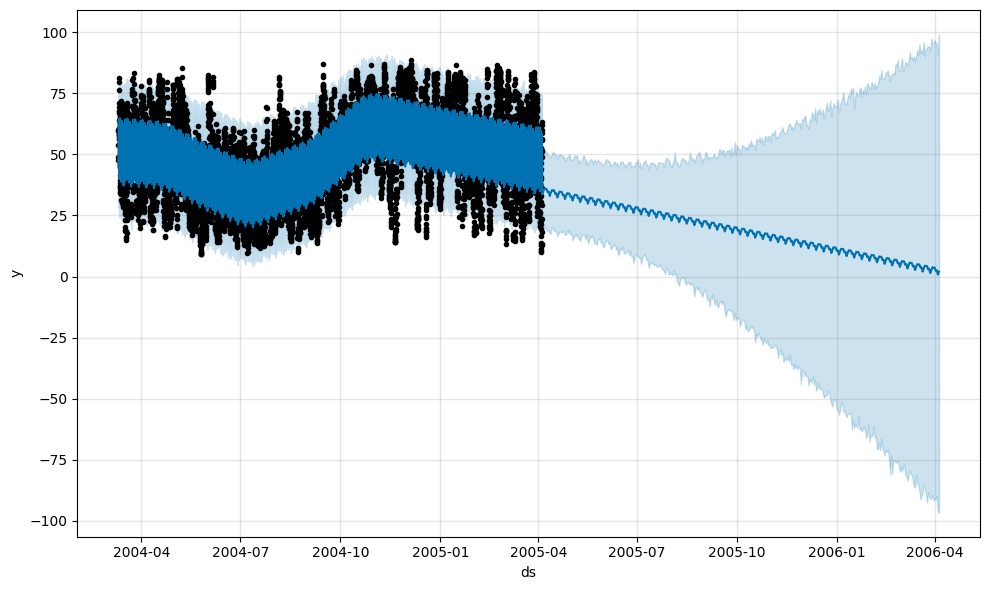

In [809]:
figl = model.plot(forecast)

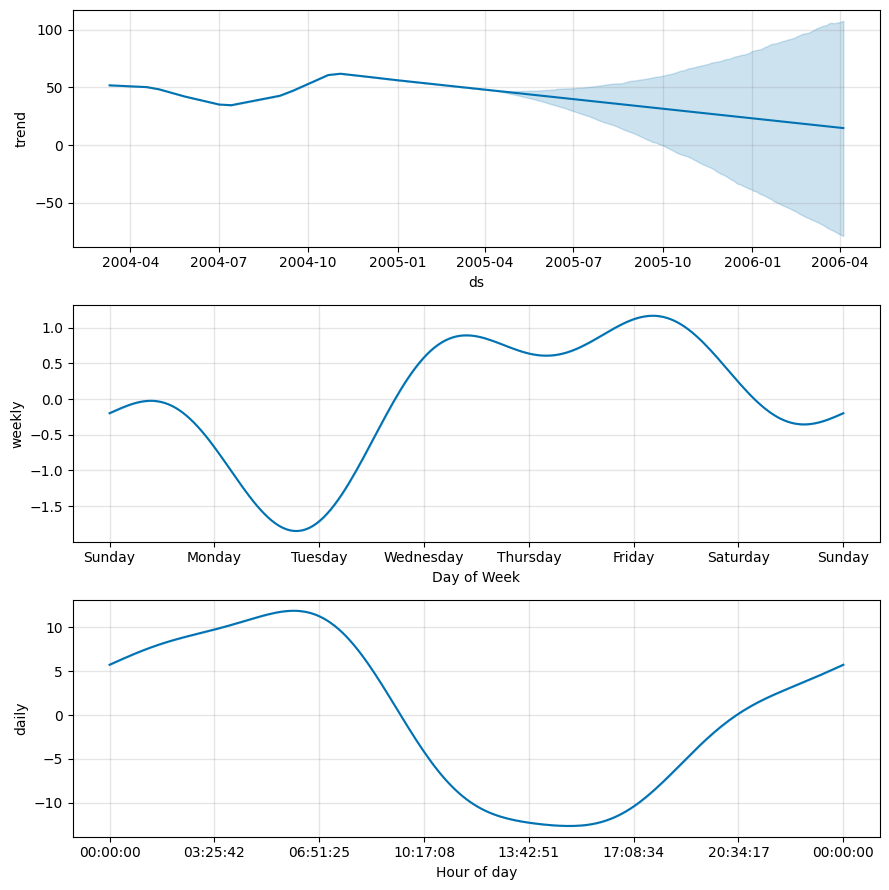

In [810]:
fig2 = model.plot_components(forecast)